<a href="https://colab.research.google.com/github/LSSTDESC/TheLastMetric/blob/master/MAFVariationalMutualInformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `TheLastMetric`: An Information Metric for Observing Strategy Optimization for Photo-z

In [3]:
!pip install --quiet git+https://github.com/google/flax

## Loading the data

Assuming a fiducial underlying galaxy catalog, we use `OpSim` to generate observed galaxy catalogs under different observing strategies.

In [4]:
!wget --quiet -O dataset.tar https://drive.google.com/u/0/uc?id=1t9_3GqjFGhpgdjiww6vlmijS-3rgVaC0&export=download
!tar -xf dataset.tar
!mv for_francois dataset

In [5]:
more dataset/README.txt

In [6]:
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')

In [7]:
available_os = ['baseline_v1.4_10yrs', 'twilight_neo_mod1_v1.4_10yrs', 'var_expt_v1.4_10yrs', 'weather_1.2_v1.4_10yrs']
os_colors = {'baseline_v1.4_10yrs': 'k', 'twilight_neo_mod1_v1.4_10yrs': '#2ca02c', 'var_expt_v1.4_10yrs': '#1f77b4', 'weather_1.2_v1.4_10yrs': '#ff7f0e'}

In [8]:
from astropy.table import Table

phot_cats, z_cats = {}, {}
for one_os in available_os:
  test_cat = Table.read('dataset/'+one_os+'/test.cat', format='ascii')


  z_cat = Table.read('dataset/'+one_os+'/zphot.cat', 
                       format='ascii', 
                       names=names_z)

  phot_cat = Table.read('dataset/'+one_os+'/test.cat', 
                       format='ascii', 
                       names=names_phot)
  phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())
  phot_cats[one_os] = phot_cat
  z_cats[one_os] = z_cat

Populating the interactive namespace from numpy and matplotlib


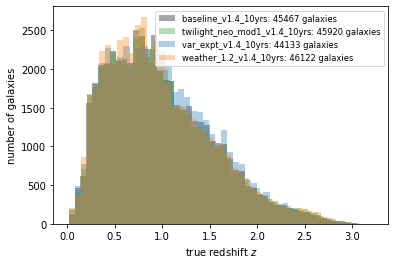

In [9]:
%pylab inline
for which_os in available_os:
  hist(z_cats[which_os]['z_true'], bins=50, alpha=0.35, color=os_colors[which_os], 
       label=which_os+': '+str(len(phot_cats[which_os]))+' galaxies')
xlabel(r'true redshift $z$')
ylabel('number of galaxies')
legend(loc='upper right', fontsize='small')
# title(str(len(phot_cats['baseline_v1.4_10yrs']))+' galaxies')

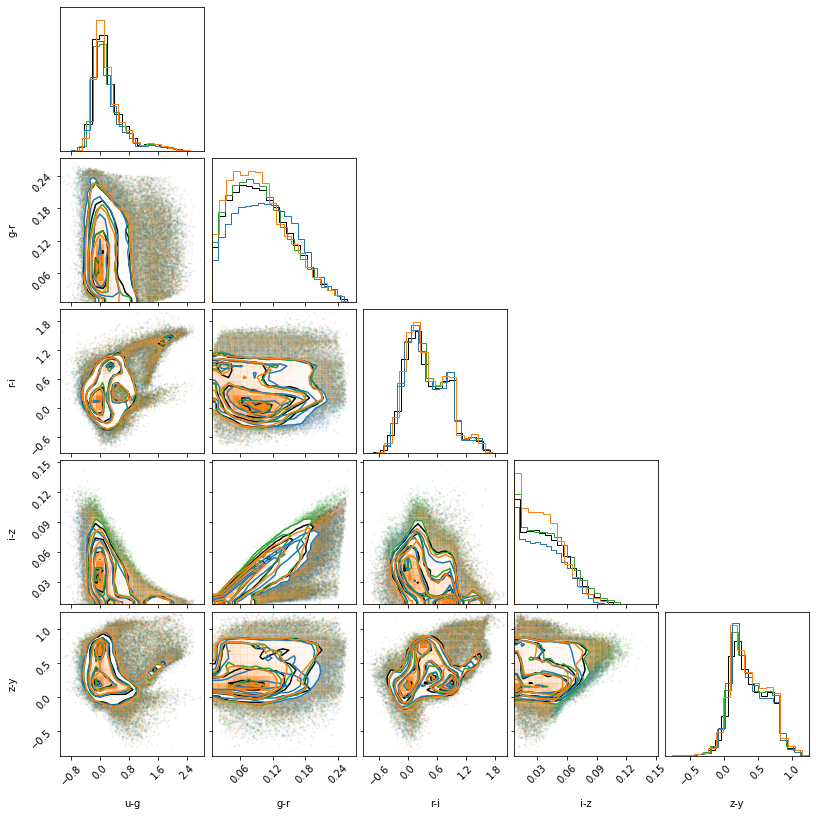

In [10]:
!pip install --quiet corner
import corner

labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']
def prep_for_corner(one_os):
  return np.array([phot_cats[one_os]['u-g'], phot_cats[one_os]['g-r'], phot_cats[one_os]['r-i'], phot_cats[one_os]['i-z'], phot_cats[one_os]['z-y']]).T
fig = corner.corner(prep_for_corner('baseline_v1.4_10yrs'), labels=labels)
for which_os in available_os[1:]:
  corner.corner(prep_for_corner(which_os), fig=fig, color=os_colors[which_os])
# corner.corner(prep_for_corner('var_expt_v1.4_10yrs'), fig=fig, color='r')
# corner.corner(prep_for_corner('weather_1.2_v1.4_10yrs'), fig=fig, color='b')

# note to self: try some of these tricks https://github.com/tommasotreu/AARV/blob/master/attic/spare-or-old-figures/DdtDa.ipynb
# also choose friendlier colors!

## Approximating the Mutual Information Lower Bound

We use a normalizing flow to approximate the distribution of redshift and photometry.

In [11]:
#@title Some useful code

import numpy as onp
import jax.numpy as jnp
 
from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
 
bijector_lib = tfp.bijectors.bijector
 
__all__ = [
    'RealNVP'
]
 
class RealNVP(bijector_lib.Bijector):
  """RealNVP 'affine coupling layer' for vector-valued events.
  Real NVP models a normalizing flow on a `D`-dimensional distribution via a
  single `D-d`-dimensional conditional distribution [(Dinh et al., 2017)][1]:
  `y[d:D] = x[d:D] * tf.exp(log_scale_fn(x[0:d])) + shift_fn(x[0:d])`
  `y[0:d] = x[0:d]`
  The last `D-d` units are scaled and shifted based on the first `d` units only,
  while the first `d` units are 'masked' and left unchanged. Real NVP's
  `shift_and_log_scale_fn` computes vector-valued quantities. For
  scale-and-shift transforms that do not depend on any masked units, i.e.
  `d=0`, use the `tfb.Affine` bijector with learned parameters instead.
  Masking is currently only supported for base distributions with
  `event_ndims=1`. For more sophisticated masking schemes like checkerboard or
  channel-wise masking [(Papamakarios et al., 2016)[4], use the `tfb.Permute`
  bijector to re-order desired masked units into the first `d` units. For base
  distributions with `event_ndims > 1`, use the `tfb.Reshape` bijector to
  flatten the event shape.
  Recall that the MAF bijector [(Papamakarios et al., 2016)][4] implements a
  normalizing flow via an autoregressive transformation. MAF and IAF have
  opposite computational tradeoffs - MAF can train all units in parallel but
  must sample units sequentially, while IAF must train units sequentially but
  can sample in parallel. In contrast, Real NVP can compute both forward and
  inverse computations in parallel. However, the lack of an autoregressive
  transformations makes it less expressive on a per-bijector basis.
  A 'valid' `shift_and_log_scale_fn` must compute each `shift` (aka `loc` or
  'mu' in [Papamakarios et al. (2016)][4]) and `log(scale)` (aka 'alpha' in
  [Papamakarios et al. (2016)][4]) such that each are broadcastable with the
  arguments to `forward` and `inverse`, i.e., such that the calculations in
  `forward`, `inverse` [below] are possible. For convenience,
  `real_nvp_default_nvp` is offered as a possible `shift_and_log_scale_fn`
  function.
  NICE [(Dinh et al., 2014)][2] is a special case of the Real NVP bijector
  which discards the scale transformation, resulting in a constant-time
  inverse-log-determinant-Jacobian. To use a NICE bijector instead of Real
  NVP, `shift_and_log_scale_fn` should return `(shift, None)`, and
  `is_constant_jacobian` should be set to `True` in the `RealNVP` constructor.
  Calling `real_nvp_default_template` with `shift_only=True` returns one such
  NICE-compatible `shift_and_log_scale_fn`.
  The `bijector_fn` argument allows specifying a more general coupling relation,
  such as the LSTM-inspired activation from [5], or Neural Spline Flow [6].
  Caching: the scalar input depth `D` of the base distribution is not known at
  construction time. The first call to any of `forward(x)`, `inverse(x)`,
  `inverse_log_det_jacobian(x)`, or `forward_log_det_jacobian(x)` memoizes
  `D`, which is re-used in subsequent calls. This shape must be known prior to
  graph execution (which is the case if using tf.layers).
  #### Examples
  ```python
  tfd = tfp.distributions
  tfb = tfp.bijectors
  # A common choice for a normalizing flow is to use a Gaussian for the base
  # distribution. (However, any continuous distribution would work.) E.g.,
  nvp = tfd.TransformedDistribution(
      distribution=tfd.MultivariateNormalDiag(loc=[0., 0., 0.]),
      bijector=tfb.RealNVP(
          num_masked=2,
          shift_and_log_scale_fn=tfb.real_nvp_default_template(
              hidden_layers=[512, 512])))
  x = nvp.sample()
  nvp.log_prob(x)
  nvp.log_prob(0.)
  ```
  For more examples, see [Jang (2018)][3].
  #### References
  [1]: Laurent Dinh, Jascha Sohl-Dickstein, and Samy Bengio. Density Estimation
       using Real NVP. In _International Conference on Learning
       Representations_, 2017. https://arxiv.org/abs/1605.08803
  [2]: Laurent Dinh, David Krueger, and Yoshua Bengio. NICE: Non-linear
       Independent Components Estimation. _arXiv preprint arXiv:1410.8516_,
       2014. https://arxiv.org/abs/1410.8516
  [3]: Eric Jang. Normalizing Flows Tutorial, Part 2: Modern Normalizing Flows.
       _Technical Report_, 2018. http://blog.evjang.com/2018/01/nf2.html
  [4]: George Papamakarios, Theo Pavlakou, and Iain Murray. Masked
       Autoregressive Flow for Density Estimation. In _Neural Information
       Processing Systems_, 2017. https://arxiv.org/abs/1705.07057
  [5]: Diederik P Kingma, Tim Salimans, Max Welling. Improving Variational
       Inference with Inverse Autoregressive Flow. In _Neural Information
       Processing Systems_, 2016. https://arxiv.org/abs/1606.04934
  [6]: Conor Durkan, Artur Bekasov, Iain Murray, George Papamakarios. Neural
       Spline Flows, 2019. http://arxiv.org/abs/1906.04032
  """
 
  def __init__(self,
               num_masked=None,
               fraction_masked=None,
               shift_and_log_scale_fn=None,
               bijector_fn=None,
               is_constant_jacobian=False,
               validate_args=False,
               name=None):
    """Creates the Real NVP or NICE bijector.
    Args:
      num_masked: Python `int`, indicating the number of units of the
        event that should should be masked. Must be in the closed interval
        `[0, D-1]`, where `D` is the event size of the base distribution.
        If the value is negative, then the last `d` units of the event are
        masked instead. Must be `None` if `fraction_masked` is defined.
      fraction_masked: Python `float`, indicating the number of units of the
        event that should should be masked. Must be in the closed interval
        `[-1, 1]`, and the value represents the fraction of the values to be
        masked. The final number of values to be masked will be the input size
        times the fraction, rounded to the the nearest integer towards zero.
        If negative, then the last fraction of units are masked instead. Must
        be `None` if `num_masked` is defined.
      shift_and_log_scale_fn: Python `callable` which computes `shift` and
        `log_scale` from both the forward domain (`x`) and the inverse domain
        (`y`). Calculation must respect the 'autoregressive property' (see class
        docstring). Suggested default
        `masked_autoregressive_default_template(hidden_layers=...)`.
        Typically the function contains `tf.Variables` and is wrapped using
        `tf.make_template`. Returning `None` for either (both) `shift`,
        `log_scale` is equivalent to (but more efficient than) returning zero.
      bijector_fn: Python `callable` which returns a `tfb.Bijector` which
        transforms the last `D-d` unit with the signature `(masked_units_tensor,
        output_units, **condition_kwargs) -> bijector`. The bijector must
        operate on scalar or vector events and must not alter the rank of its
        input.
      is_constant_jacobian: Python `bool`. Default: `False`. When `True` the
        implementation assumes `log_scale` does not depend on the forward domain
        (`x`) or inverse domain (`y`) values. (No validation is made;
        `is_constant_jacobian=False` is always safe but possibly computationally
        inefficient.)
      validate_args: Python `bool` indicating whether arguments should be
        checked for correctness.
      name: Python `str`, name given to ops managed by this object.
    Raises:
      ValueError: If both or none of `shift_and_log_scale_fn` and `bijector_fn`
          are specified.
    """
    parameters = dict(locals())
    name = name or 'real_nvp'
    with tf.name_scope(name) as name:
      # At construction time, we don't know input_depth.
      self._input_depth = None
      if num_masked is not None and fraction_masked is not None:
        raise ValueError('Exactly one of `num_masked` and '
                         '`fraction_masked` should be specified.')
 
      if num_masked is not None:
        if int(num_masked) != num_masked:
          raise TypeError('`num_masked` must be an integer. Got: {} of type {}'
                          ''.format(num_masked, type(num_masked)))
        self._num_masked = int(num_masked)
        self._fraction_masked = None
        self._reverse_mask = self._num_masked < 0
      else:
        if not np.issubdtype(type(fraction_masked), np.floating):
          raise TypeError('`fraction_masked` must be a float. Got: {} of type '
                          '{}'.format(fraction_masked, type(fraction_masked)))
        if np.abs(fraction_masked) >= 1.:
          raise ValueError(
              '`fraction_masked` must be in (-1, 1), but is {}.'.format(
                  fraction_masked))
        self._num_masked = None
        self._fraction_masked = float(fraction_masked)
        self._reverse_mask = self._fraction_masked < 0
 
      if shift_and_log_scale_fn is not None and bijector_fn is not None:
        raise ValueError('Exactly one of `shift_and_log_scale_fn` and '
                         '`bijector_fn` should be specified.')
 
      if shift_and_log_scale_fn:
        def _bijector_fn(x0, input_depth, **condition_kwargs):
          shift, log_scale = shift_and_log_scale_fn(x0, input_depth,
                                                    **condition_kwargs)
          return affine_scalar.AffineScalar(shift=shift, log_scale=log_scale)
 
        bijector_fn = _bijector_fn
      #
      # if validate_args:
      #   bijector_fn = _validate_bijector_fn(bijector_fn)
 
      # Still do this assignment for variable tracking.
      self._shift_and_log_scale_fn = shift_and_log_scale_fn
      self._bijector_fn = bijector_fn
 
      super(RealNVP, self).__init__(
          forward_min_event_ndims=1,
          is_constant_jacobian=is_constant_jacobian,
          validate_args=validate_args,
          parameters=parameters,
          name=name)
 
  @property
  def _masked_size(self):
    masked_size = (
        self._num_masked if self._num_masked is not None else int(
            np.round(self._input_depth * self._fraction_masked)))
    return masked_size
 
  def _cache_input_depth(self, x):
    if self._input_depth is None:
      self._input_depth = x.shape[-1]
      if self._input_depth is None:
        raise NotImplementedError(
            'Rightmost dimension must be known prior to graph execution.')
 
      if abs(self._masked_size) >= self._input_depth:
        raise ValueError(
            'Number of masked units {} must be smaller than the event size {}.'
            .format(self._masked_size, self._input_depth))
 
  def _bijector_input_units(self):
    return self._input_depth - abs(self._masked_size)
 
  def _forward(self, x, **condition_kwargs):
    self._cache_input_depth(x)
 
    x0, x1 = x[..., :self._masked_size], x[..., self._masked_size:]
 
    if self._reverse_mask:
      x0, x1 = x1, x0
 
    y1 = self._bijector_fn(x0, self._bijector_input_units(),
                           **condition_kwargs).forward(x1)
 
    if self._reverse_mask:
      y1, x0 = x0, y1
 
    y = tf.concat([x0, y1], axis=-1)
    return y
 
  def _inverse(self, y, **condition_kwargs):
    self._cache_input_depth(y)
 
    y0, y1 = y[..., :self._masked_size], y[..., self._masked_size:]
 
    if self._reverse_mask:
      y0, y1 = y1, y0
 
    x1 = self._bijector_fn(y0, self._bijector_input_units(),
                           **condition_kwargs).inverse(y1)
 
    if self._reverse_mask:
      x1, y0 = y0, x1
 
    x = tf.concat([y0, x1], axis=-1)
    return x
 
  def _forward_log_det_jacobian(self, x, **condition_kwargs):
    self._cache_input_depth(x)
 
    x0, x1 = x[..., :self._masked_size], x[..., self._masked_size:]
 
    if self._reverse_mask:
      x0, x1 = x1, x0
 
    return self._bijector_fn(x0, self._bijector_input_units(),
                             **condition_kwargs).forward_log_det_jacobian(
                                 x1, event_ndims=1)
 
  def _inverse_log_det_jacobian(self, y, **condition_kwargs):
    self._cache_input_depth(y)
 
    y0, y1 = y[..., :self._masked_size], y[..., self._masked_size:]
 
    if self._reverse_mask:
      y0, y1 = y1, y0
 
    return self._bijector_fn(y0, self._bijector_input_units(),
                             **condition_kwargs).inverse_log_det_jacobian(
                                 y1, event_ndims=1)

In [12]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
import flax 
from flax import nn
import jax
import jax.numpy as np
import numpy as onp

tfb = tfp.bijectors
tfd = tfp.distributions

In [13]:
@nn.module
def NeuralSpline(x, nunits=1, nbins=32):
  def bin_positions(x):
    x = np.reshape(x, [-1, nunits, nbins])
    return nn.activation.softmax(x, axis=-1) *  (2. - nbins * 1e-2) + 1e-2
  
  def slopes(x):
    x = np.reshape(x, [-1, nunits, nbins - 1])
    return nn.activation.softplus(x) + 1e-2

  # Let's have one more non stupid layer
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.leaky_relu(nn.Dense(net, 128))

  bin_widths = bin_positions(nn.Dense(net, nunits*nbins))
  bin_heights = bin_positions(nn.Dense(net, nunits*nbins))
  knot_slopes = slopes(nn.Dense(net, nunits*(nbins-1)))

  return tfb.RationalQuadraticSpline(
            bin_widths=bin_widths,
            bin_heights=bin_heights,
            knot_slopes=knot_slopes)

In [14]:
@nn.module
def ConditionalDensityEstimator(x):
  # Some input processing
  net = nn.BatchNorm(x)
  net = nn.leaky_relu(nn.Dense(net, 512))
  net = nn.BatchNorm(net)
  net = nn.leaky_relu(nn.Dense(net, 512))
  net = nn.BatchNorm(net)
  net = nn.leaky_relu(nn.Dense(net, 512))


  loc = nn.Dense(net,1)
  scale= nn.softplus(nn.Dense(net,1))

  # spline1 = NeuralSpline.shared(name='spline1')
  # spline2 = NeuralSpline.shared(name='spline2')  

  # And here we define somdistributione simple normalizing flow
  bijector_chain = tfb.Chain([       
        tfb.Scale(3.5/2.),
        tfb.Shift(1.0),
        tfb.Tanh(),
        # tfb.Scale(10.),        
        # spline1(net),    
        # tfb.Scale(0.1)
  ])

  distribution = tfd.TransformedDistribution(tfd.Normal(loc=loc, scale=scale),
                                             bijector_chain)
  return distribution

TODO: could also get mutual information of true and photometric redshift to check information loss due to intermediate step. . .

In [15]:
batch_size = 512
def get_batch(which_os='baseline_v1.4_10yrs'):
  phot_cat = phot_cats[which_os]
  inds = onp.random.choice(len(phot_cat), size=batch_size)
  x = np.stack([phot_cat['u-g'][inds], phot_cat['g-r'][inds], phot_cat['r-i'][inds],
                phot_cat['i-z'][inds], phot_cat['z-y'][inds] ]).astype('float32').T
  y = np.array(phot_cat['z_true'][inds]).astype('float32').reshape((-1,1))
  return {'x':x, 'y':y}

In [16]:
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(model):
    distribution = model(batch['x'])
    loss = - np.mean(distribution.log_prob(batch['y']))
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)

  optimizer = optimizer.apply_gradient(grad)
  return optimizer, l

In [17]:
_, initial_params = ConditionalDensityEstimator.init(jax.random.PRNGKey(0), jnp.zeros((1,5), dtype=np.float32))

model = flax.nn.Model(ConditionalDensityEstimator, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

In [18]:
all_losses, all_dist, all_batch = {}, {}, {}

for which_os in available_os:
  losses = []
  dist = []
  optimizer = flax.optim.Adam(learning_rate=0.001).create(model)
  for epoch in range(10000):
    batch = get_batch(which_os=which_os)
    optimizer, l = train_step(optimizer, batch)
    if epoch % 1000 == 0:
      print(which_os, epoch, l)
    losses.append(l)
  dist = optimizer.target(batch['x'])
  all_dist[which_os] = dist
  all_losses[which_os] = losses
  all_batch[which_os] = batch

baseline_v1.4_10yrs 0 31.204887
baseline_v1.4_10yrs 1000 -0.49969143
baseline_v1.4_10yrs 2000 -1.0720162
baseline_v1.4_10yrs 3000 -1.0957863
baseline_v1.4_10yrs 4000 -1.2115973
baseline_v1.4_10yrs 5000 -1.3165572
baseline_v1.4_10yrs 6000 -1.4177074
baseline_v1.4_10yrs 7000 -1.4450665
baseline_v1.4_10yrs 8000 -1.4470308
baseline_v1.4_10yrs 9000 -1.3384387
twilight_neo_mod1_v1.4_10yrs 0 32.79413
twilight_neo_mod1_v1.4_10yrs 1000 -0.24708833
twilight_neo_mod1_v1.4_10yrs 2000 -0.7909133
twilight_neo_mod1_v1.4_10yrs 3000 -1.0764159
twilight_neo_mod1_v1.4_10yrs 4000 -1.1907735
twilight_neo_mod1_v1.4_10yrs 5000 -1.3873814
twilight_neo_mod1_v1.4_10yrs 6000 -1.3913441
twilight_neo_mod1_v1.4_10yrs 7000 -1.1313078
twilight_neo_mod1_v1.4_10yrs 8000 -1.395798
twilight_neo_mod1_v1.4_10yrs 9000 -1.4552234
var_expt_v1.4_10yrs 0 28.34494
var_expt_v1.4_10yrs 1000 -0.27486825
var_expt_v1.4_10yrs 2000 -0.7223627
var_expt_v1.4_10yrs 3000 -1.3248473
var_expt_v1.4_10yrs 4000 -1.2936168
var_expt_v1.4_10yrs 50

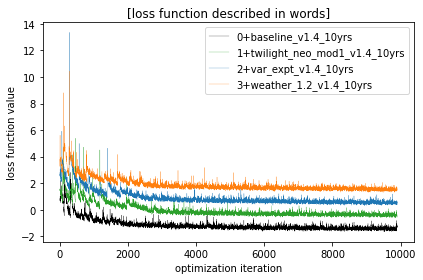

In [19]:
# plot(np.array(losses[100:]))
# xlabel('optimization iteration')
# ylabel('loss function value')
# title('[loss function described in words]')

for i, which_os in enumerate(available_os):
  plot(np.array(all_losses[which_os][100:])+float(i), linewidth=0.25, color=os_colors[which_os], label=str(i)+'+'+which_os)
legend(loc='upper right')
xlabel('optimization iteration')
ylabel('loss function value')
title('[loss function described in words]')
tight_layout()

In [20]:
# batch = get_batch()
# dist = optimizer.target(batch['x'])

In [21]:
tx = np.linspace(0,3.5,100)
all_logp = {}
for which_os in available_os:
  logp = all_dist[which_os].log_prob(tx)
  all_logp[which_os] = logp

In [22]:
# tx = np.linspace(0,3.5,100)
# logp = dist.log_prob(tx)

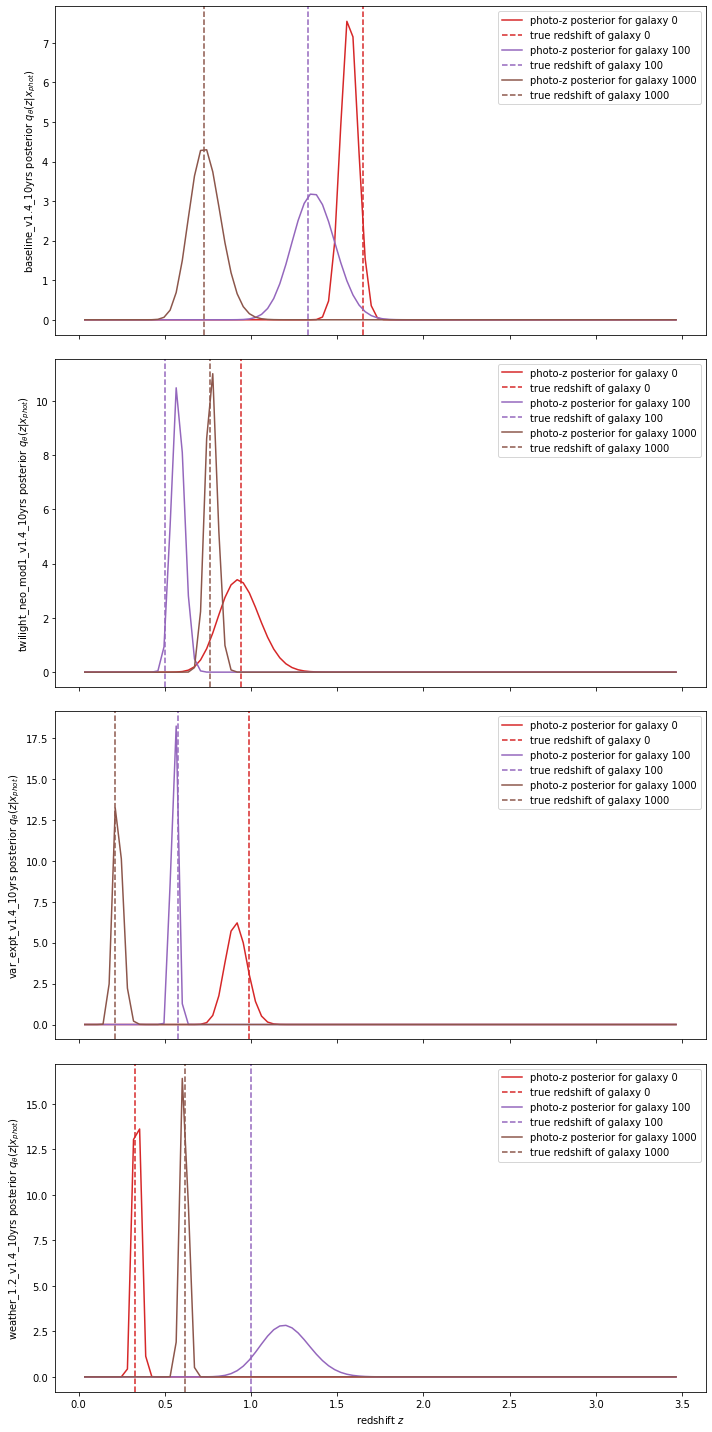

In [23]:
# plot(tx, np.exp(logp[0]), label='photo-z posterior for galaxy 0')
# axvline(batch['y'][0], linestyle='--', color='C0', label='true redshift of galaxy 0')
# plot(tx, np.exp(logp[100]), label='photo-z posterior for galaxy 100')
# axvline(batch['y'][100], linestyle='--', color='C1', label='true redshift of galaxy 100')
# plot(tx, np.exp(logp[1000]), label='photo-z posterior for galaxy 1000')
# axvline(batch['y'][1000], linestyle='--', color='C2', label='true redshift of galaxy 1000')
# legend(loc='upper right')
# xlabel(r'redshift $z$')
# ylabel(r'posterior probability $q_\theta(z | x_{phot})$')
# title('A few example posteriors approximated by the normalizing flow')

fig, ax = subplots(4, 1, figsize=(10, 20), sharex=True)
for i, which_os in enumerate(available_os):
  ax[i].set_ylabel(which_os+r' posterior $q_{\theta}(z | x_{phot})$')
  # ax[i].set_title(which_os)
  logp = all_logp[which_os]
  batch = all_batch[which_os]
  ax[i].plot(tx, np.exp(logp[0]), color='#d62728', label='photo-z posterior for galaxy 0')
  ax[i].axvline(batch['y'][0], linestyle='--', color='#d62728', label='true redshift of galaxy 0')
  ax[i].plot(tx, np.exp(logp[100]), color='#9467bd',  label='photo-z posterior for galaxy 100')
  ax[i].axvline(batch['y'][100], linestyle='--', color='#9467bd', label='true redshift of galaxy 100')
  ax[i].plot(tx, np.exp(logp[1000]), color='#8c564b', label='photo-z posterior for galaxy 1000')
  ax[i].axvline(batch['y'][1000], linestyle='--', color='#8c564b', label='true redshift of galaxy 1000')
  ax[i].legend(loc='upper right')
  if i == 3:
    ax[i].set_xlabel(r'redshift $z$')
fig.tight_layout()
fig.show()

This plot should show the redshift posterior distribution for given photometry $q_\theta(z | x_{phot})$. 

We are going to use that to compute our lower bound on the mutual information

$$I(z; x_{phot})  \geq \mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]  + H(z)$$ 

The second term in this bound only depends on the true redshift distribution, which stays constant between observing strategies. Only the first term depends on the observed photometry, so it is the only one we have to compare between `OpSim` runs.

In [24]:
all_milb = {}
for which_os in available_os:
  phot_cat = phot_cats[which_os]

  x = np.stack([phot_cat['u-g'], phot_cat['g-r'], phot_cat['r-i'],
              phot_cat['i-z'],phot_cat['z-y']]).astype('float32').T
  y = np.array(phot_cat['z_true']).astype('float32').reshape((-1,1))

  mutual_information_lower_bound = model(x).log_prob(y)
  all_milb[which_os] = mutual_information_lower_bound

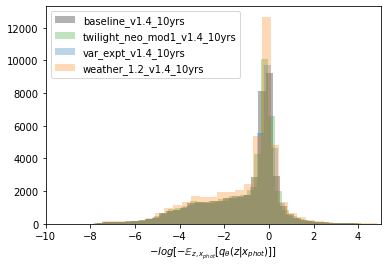

In [25]:
# surprisingly not so different from one another, but I think we do anticipate "weather" to have more weight at low values of the lower bound
for which_os in available_os:
  mutual_information_lower_bound = all_milb[which_os]
  hist(-1.*np.log(-1.*mutual_information_lower_bound.flatten()), bins=50, alpha=0.3, color=os_colors[which_os], label=which_os)
  xlabel(r'$-log[-\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]]$')
xlim(-10., 5.)
legend(loc='upper left')
# semilogy()

In [26]:
# #not very informative

# fig, ax = subplots(4, 5, figsize=(25, 20), sharey=True)
# for j, which_os in enumerate(available_os):
#   phot_cat = phot_cats[which_os]
#   mutual_information_lower_bound = all_milb[which_os]
#   for i, col in enumerate(['u-g', 'g-r', 'r-i', 'i-z', 'z-y']):
#     ax[j][i].set_xlabel(col)
#     img = ax[j][i].scatter(phot_cat[col], mutual_information_lower_bound.flatten(), c=phot_cat['z_true'], cmap=mpl.cm.viridis_r, s=0.1)
#     if i == 0:
#       ax[j][i].set_ylabel(which_os+r' $\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#     if i == 4:
#       fig.colorbar(img, ax=ax[j][i], label=r'redshift $z$')
#       ax[j][i].set_ylim(-5., 1.)
# fig.tight_layout()
# fig.show()

In [27]:
# Contour/KDE won't work because of crazy outliers. . .

# from scipy import stats as sps
# def density_estimation(m1, m2):
#     x = np.linspace(0., 2.5, 64)
#     y = np.linspace(-5., 1., 64)
#     X, Y = np.meshgrid(x, y)
#     # X, Y = npo.mgrid[0.:2.5:64j, -5.:1.:64j]                                                     
#     positions = npo.vstack([X.ravel(), Y.ravel()])                                                       
#     values = npo.vstack([m1, m2])                                                                        
#     kernel = sps.gaussian_kde(values)                                                                 
#     Z = np.reshape(kernel(positions).T, X.shape)
#     return X, Y, Z
# (x, y, z) = density_estimation(phot_cat['z_true'], mutual_information_lower_bound.flatten())
# contour(x, y, z)


In [28]:
# for which_os in available_os:
#   phot_cat = phot_cats[which_os]
#   mutual_information_lower_bound = all_milb[which_os]
#   hist2d (phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64, 
#         range=[[0,2.5], [-5,1]], cmap=mpl.cm.viridis_r, norm=mpl.colors.LogNorm());
#   colorbar()
#   xlabel(r'redshift $z$')
#   ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   title(which_os)
#   show()

# # hist2d (phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64, 
# #         range=[[0,2.5], [-5,1]], cmap=mpl.cm.viridis_r, norm=mpl.colors.LogNorm());
# # colorbar()

# # # scatter(phot_cat['z_true'], mutual_information_lower_bound.flatten(), s=0.1)
# # # xlim(0., 2.5)
# # # ylim(-5., 1.)

# # xlabel(r'redshift $z$')
# # ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# # title('TheLastMetric on '+just_one_os)

In [33]:
# for which_os in available_os:
#   phot_cat = phot_cats[which_os]
#   # for zran in 
#   mutual_information_lower_bound = all_milb[which_os]
#   hist2d (phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64, 
#         range=[[0,2.5], [-5,1]], cmap=mpl.cm.viridis_r, norm=mpl.colors.LogNorm());
#   colorbar()
#   xlabel(r'redshift $z$')
#   ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   title(which_os)
# show()

# # hist2d (phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64, 
# #         range=[[0,2.5], [-5,1]], cmap=mpl.cm.viridis_r, norm=mpl.colors.LogNorm());
# # colorbar()

# # # scatter(phot_cat['z_true'], mutual_information_lower_bound.flatten(), s=0.1)
# # # xlim(0., 2.5)
# # # ylim(-5., 1.)

# # xlabel(r'redshift $z$')
# # ylabel(r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# # title('TheLastMetric on '+just_one_os)

[DeviceArray(-0.562198, dtype=float32), DeviceArray(0.562198, dtype=float32)]


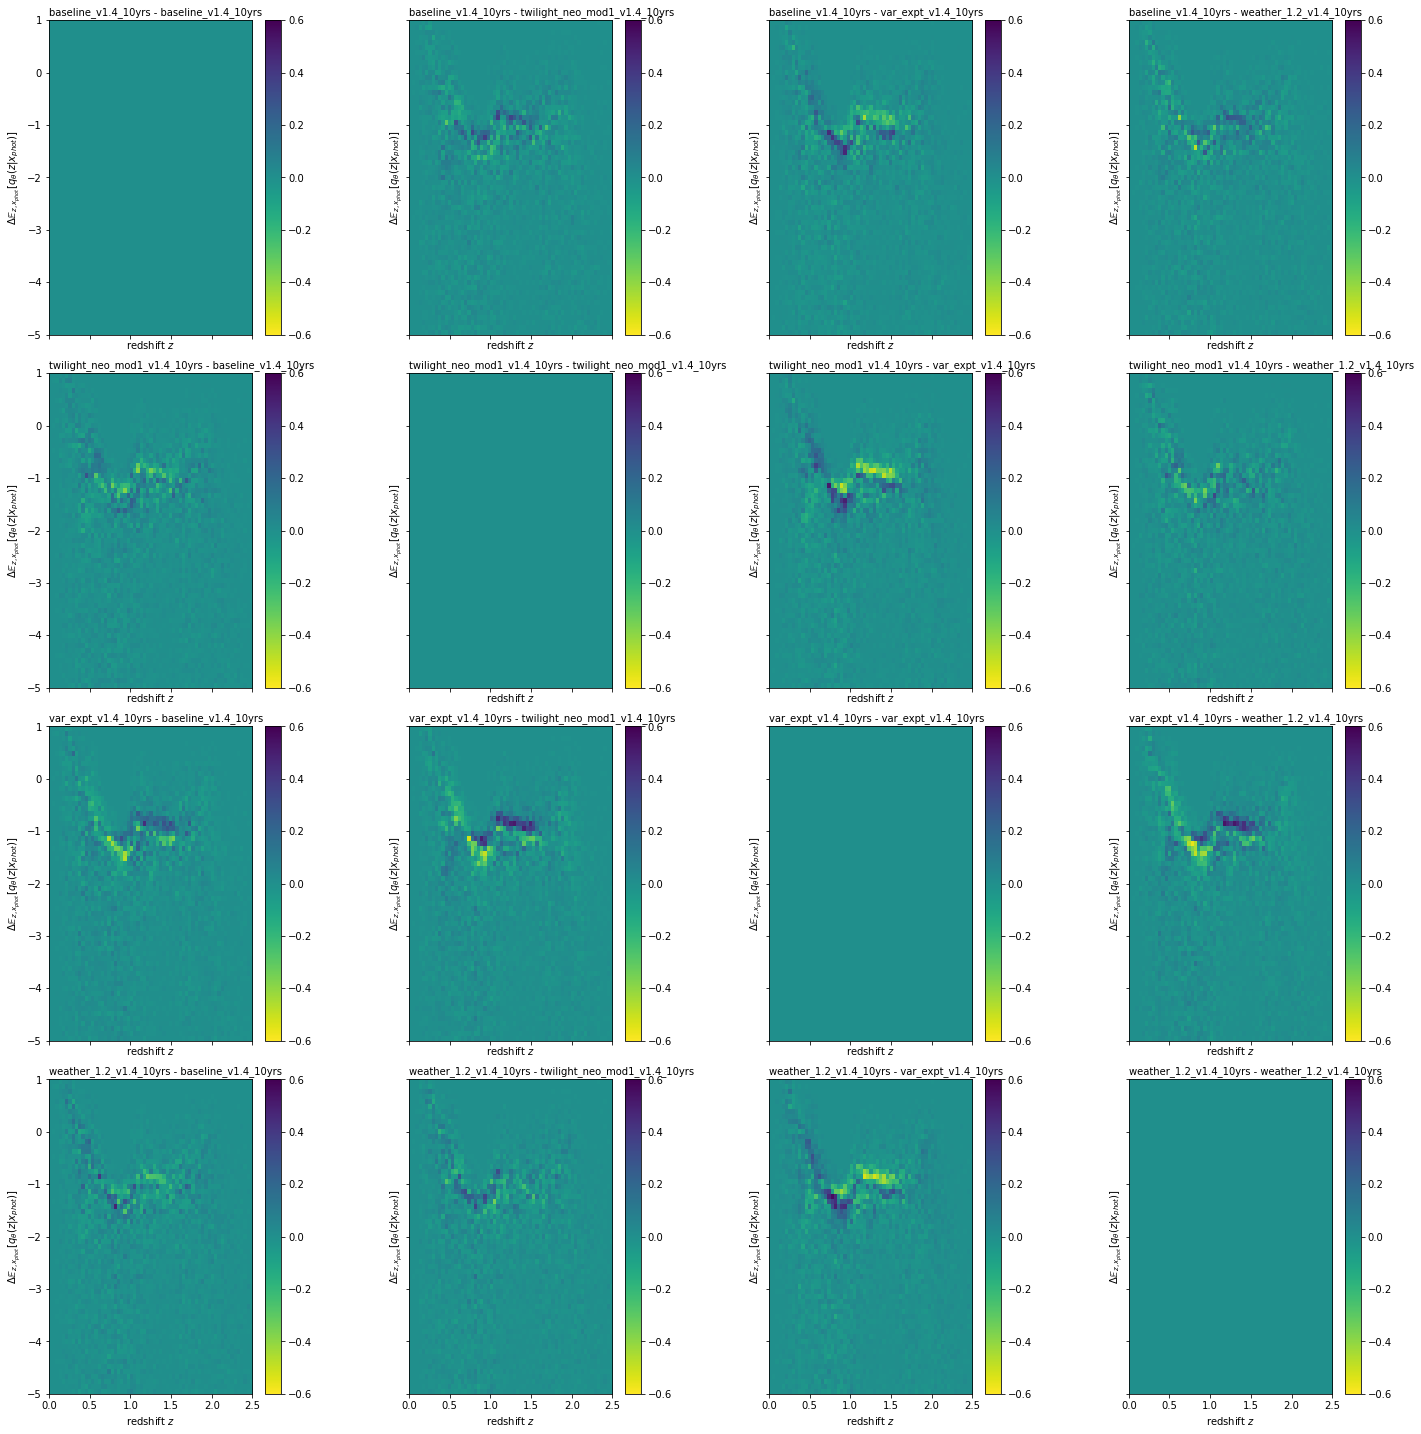

In [30]:
# TODO: get rid of diagonal
fig, ax = subplots(4, 4, figsize=(20, 20), sharey=True, sharex=True)
hists = {}
for j, base_os in enumerate(available_os):
  phot_cat = phot_cats[base_os]
  mutual_information_lower_bound = all_milb[base_os]
  x = np.linspace(0., 2.5, 64)
  y = np.linspace(-5., 1., 64)
  h, x, y = np.histogram2d(phot_cat['z_true'], mutual_information_lower_bound.flatten(), bins=(x, y), density=True)#64)#, extent=np.array([[0.,2.5], [-5.,1.]]))
  hists[base_os] = h
extrema = [0., 0.]
for j, base_os in enumerate(available_os):
  for i, comp_os in enumerate(available_os):
    diff_hist = hists[base_os] - hists[comp_os]
    comp_extrema = [np.min(diff_hist), np.max(diff_hist)]
    extrema = [min(comp_extrema[0], extrema[0]), max(comp_extrema[1], extrema[1])]
    img = ax[j][i].imshow(diff_hist.T, origin='lower', cmap=mpl.cm.viridis_r, vmin=-0.6, vmax=0.6, extent=[0.,2.5,-5.,1.], aspect='auto')
    ax[j][i].text(0., 1.1, base_os+' - '+comp_os)
    ax[j][i].set_ylabel(r'$\Delta\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
    fig.colorbar(img, ax=ax[j][i])
    ax[j][i].set_xlabel(r'redshift $z$')
fig.tight_layout()
fig.show()
print(extrema)

In [31]:
# next step: make corner plot of differences between distributions as 2D histograms, since contour/KDE fails

In [32]:
# mutual_information_lower_bound

## Computing the bound for various opsim runs

In [67]:
test_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/test.cat', format='ascii')

names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
z_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/zphot.cat', 
                       format='ascii', 
                       names=names_z)

names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')
phot_cat = Table.read('dataset/weather_1.2_v1.4_10yrs/test.cat', 
                       format='ascii', 
                       names=names_phot)
phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())

In [68]:
batch_size = 512
def get_batch():
  inds = onp.random.choice(len(phot_cat), size=batch_size)
  x = np.stack([phot_cat['u-g'][inds], phot_cat['g-r'][inds], phot_cat['r-i'][inds],
                phot_cat['i-z'][inds],phot_cat['z-y'][inds] ]).astype('float32').T
  y = np.array(phot_cat['z_true'][inds]).astype('float32').reshape((-1,1))
  return {'x':x, 'y':y}

In [69]:
_, initial_params = ConditionalDensityEstimator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 5), np.float32)])

model = flax.nn.Model(ConditionalDensityEstimator, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

losses = []

AssertionError: ignored

In [ ]:
for epoch in range(10000):
  batch = get_batch()
  optimizer, l = train_step(optimizer, batch)
  if epoch % 1000 == 0:
    print(epoch, l)
  losses.append(l)

In [ ]:
plot(np.array(losses[2000:]))

In [ ]:
batch = get_batch()
dist = optimizer.target(batch['x'])

In [ ]:
tx = np.linspace(0,3.5,100)
logp = dist.log_prob(tx)

In [ ]:
plot(tx, np.exp(logp[0]))
axvline(batch['y'][0], color='C0')
plot(tx, np.exp(logp[1]))
axvline(batch['y'][1], color='C1')

In [ ]:
x = np.stack([phot_cat['u-g'], phot_cat['g-r'], phot_cat['r-i'],
              phot_cat['i-z'],phot_cat['z-y']]).astype('float32').T
y = np.array(phot_cat['z_true']).astype('float32').reshape((-1,1))

mutual_information_lower_bound = model(x).log_prob(y)

In [ ]:
np.mean(mutual_information_lower_bound)

In [ ]:
hist2d(phot_cat['z_true'], mutual_information_lower_bound.flatten(), 64,
       range=[[0,2.5], [-5,1]]);
xlabel('Redshift')
ylabel(r'$\mathbb{E}_{z, phot} \left[ q_\theta(z | phot ) \right]$')
title('weather_1.2_v1.4_10yrs')

In [ ]:
mutual_information_lower_bound.shape